# Basic Settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.optim import Adam

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.models import resnet50, vgg16_bn, alexnet, googlenet

import time
import math
import random
import matplotlib.pyplot as plt

from collections import Counter
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import seaborn as sns

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

os.chdir('/content/drive/My Drive/Colab Notebooks/6771_project/')
directory_path = './'

cuda


# Load Dataset

load dataset and show number of images in training and testing dataset

In [4]:
def load_dataset(directory_path):
  image_transforms = transforms.Compose(
                    [
                     transforms.ToTensor(),
                     #transforms.Normalize(mean=(0.54029465, 0.4816059, 0.45236158), std=(0.2540607, 0.24196939, 0.23964395)),
                     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                     transforms.Resize((128,128))
                    ])
  
  dataset = ImageFolder(
                        root = directory_path,
                        transform = image_transforms
                        )
  return dataset
 
train_dataset = load_dataset(directory_path+'data/train')
test_dataset = load_dataset(directory_path+'data/test')

print('Total number of images in training dataset: ',len(train_dataset))
# print('Classes')
# display(train_dataset.class_to_idx)

print('Total number of images in testing dataset: ', len(test_dataset))
# print('Classes')
# display(test_dataset.class_to_idx)

train_idxs = np.arange(len(train_dataset))
train_labels = np.array(train_dataset.targets)[train_idxs]

test_idxs = np.arange(len(test_dataset))
test_labels = np.array(test_dataset.targets)[test_idxs]

Total number of images in training dataset:  15042
Total number of images in testing dataset:  2099


show the English name of each food class

In [5]:
food_list = pd.read_csv(directory_path + 'data/food_list.csv')
# print(food_list)

def mapIdxToName(food_list, idxs=[]):
  selected_food_list = food_list[food_list['List No.'].isin(idxs)]
  return selected_food_list[['List No.', 'English Name']]

num_classes = len(train_dataset.classes)
classes = mapIdxToName(food_list, np.arange(num_classes))
print(classes)

    List No.                           English Name
0          0                              Mapo Tofu
1          1                Home style sauteed Tofu
2          2                             Fried Tofu
3          3                              Bean curd
4          4                            Stinky tofu
5          5                            Potato silk
6          6                       Pan fried potato
7          7                       Pan fried potato
8          8              Braised beans with potato
9          9  Fried Potato, Green Pepper & Eggplant
10        10                           French fries
11        11                     Yu-Shiang Eggplant
12        12                 Mashed garlic eggplant
13        13               Eggplant with mince pork
14        14                          Spicy cabbage
15        15                           Sour cabbage
16        16                   Steamed Baby Cabbage
17        17                       Shredded cabbage
18        18

show a sample from each food class

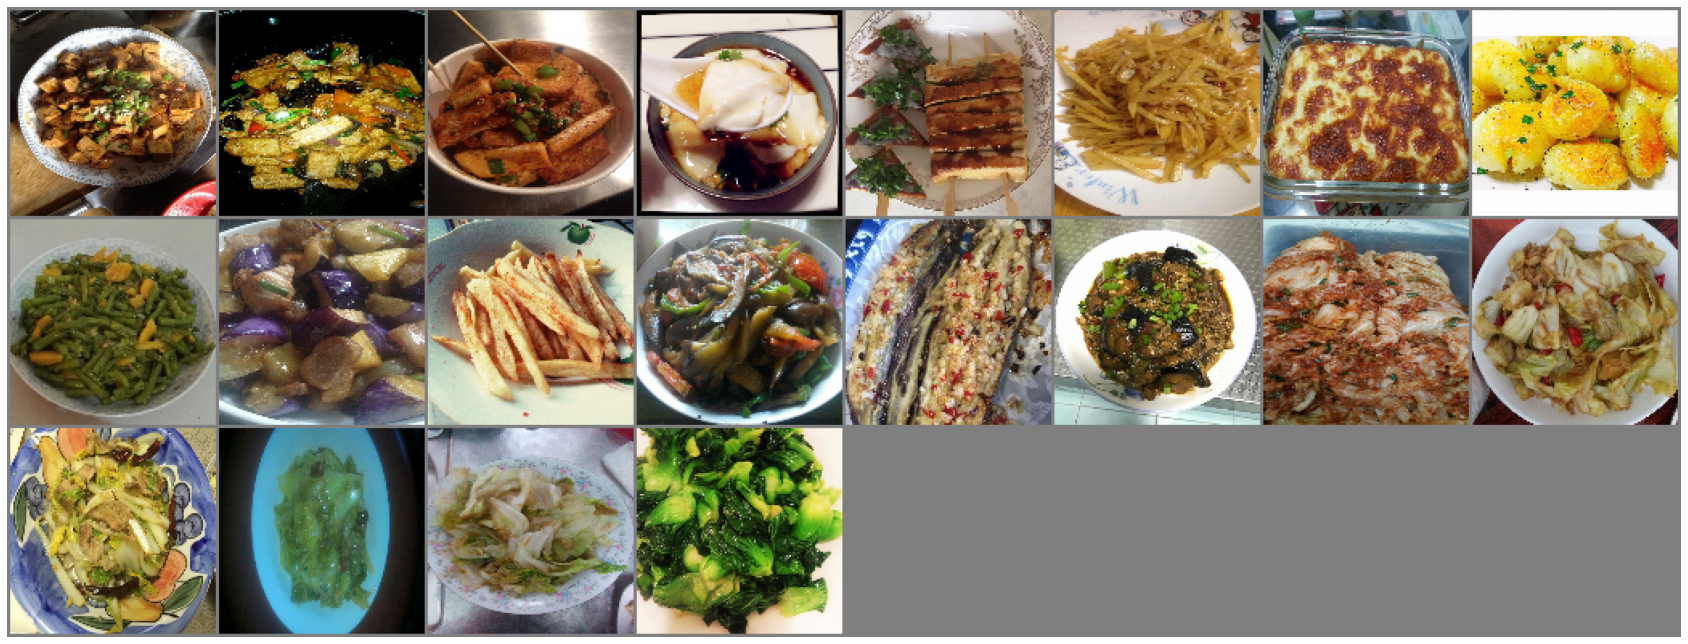

In [6]:
def show_examples(train_dataset, train_labels):
  num_classes = len(train_dataset.classes)
  train_labels_dist = Counter(train_labels)
  i = 0
  sample_idxs = []
  for j in train_labels_dist.values():
    sample_idxs.append(i)
    i = i + j
  img = make_grid([train_dataset[idx][0] for idx in sample_idxs])
  img = img / 2 + 0.5
  plt.figure(figsize=(30, 30))
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.axis('off')

show_examples(train_dataset, train_labels)

show number of images in each classes of training and testing dataset

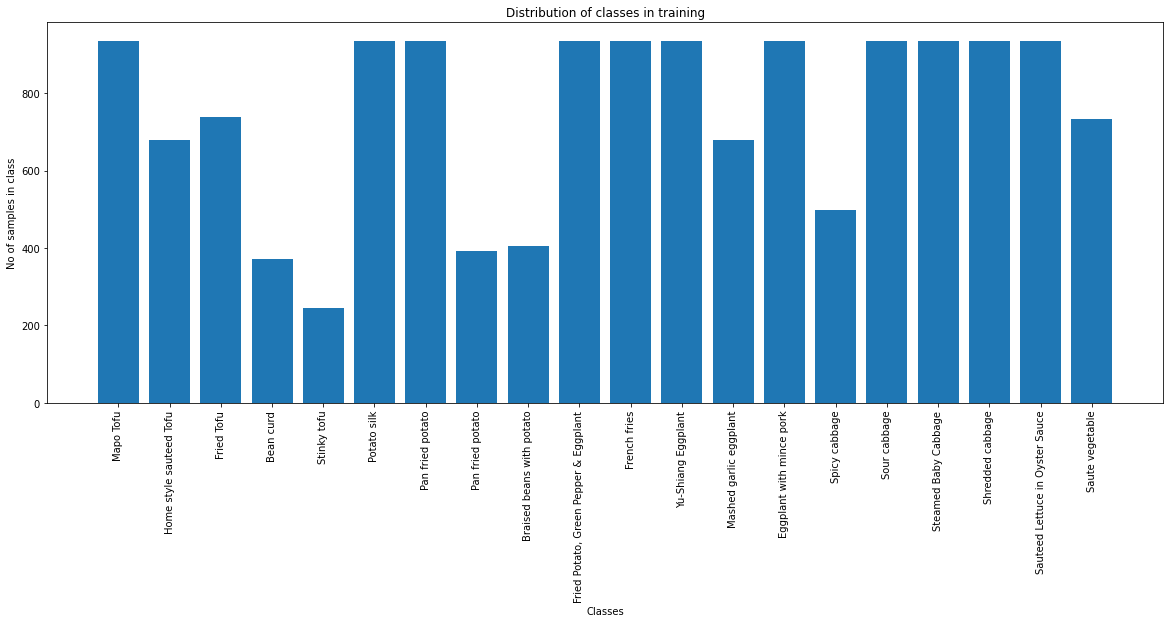

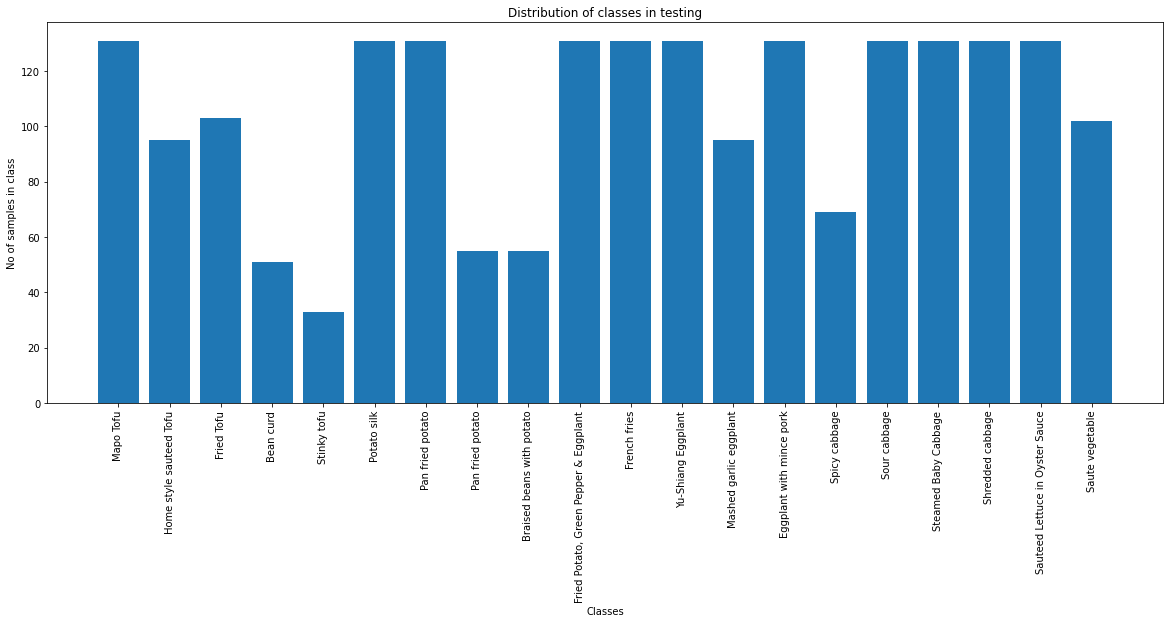

In [7]:
plt.figure(figsize=(20,7))
plt.title('Distribution of classes in training')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(num_classes),classes['English Name'], rotation = 90)
train_labels_dist = Counter(train_labels)
plt.bar(train_labels_dist.keys(), train_labels_dist.values())

plt.figure(figsize=(20,7))
plt.title('Distribution of classes in testing')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(num_classes),classes['English Name'], rotation = 90)
test_labels_dist = Counter(test_labels)
plt.bar(test_labels_dist.keys(), test_labels_dist.values());


# Build models

In [8]:
class DNN_block(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dims=[]):
        super(DNN_block, self).__init__()
        linear_array = []

        activation_func = nn.ReLU()

        if hidden_dims is None or len(hidden_dims) == 0:
            linear_array.append(nn.Linear(input_dim, output_dim))
        else:
            hidden_input_dim = input_dim
            for hidden_output_dim in hidden_dims:
                linear_array.append(nn.Linear(hidden_input_dim, hidden_output_dim))
                cur = hidden_output_dim
                linear_array.append(activation_func)
            linear_array.append(nn.Linear(cur, output_dim))

        self.seq = nn.Sequential(*linear_array)

    def forward(self, x):
        return self.seq(x)

## CNN

In [9]:
class FoodCNN(nn.Module):  #CNN 
    def __init__(self):
        super(FoodCNN, self,).__init__()
        self.conv_layer = nn.Sequential(
            
            nn.Conv2d(3, 6, 5, 1, 1),  
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.AvgPool2d(2, 2, 0),      

            nn.Conv2d(6, 16, 5, 1, 1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2, 2, 0),      

            nn.Conv2d(16, 64, 5, 1, 1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2, 2, 0),      

            nn.Conv2d(64, 256, 5, 1, 1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(2, 2, 0),       
            
            nn.Conv2d(256, 256, 5, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(2, 2, 0),      
        )
        self.fc_layer = DNN_block(1024, 20, [256])

    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(out.size()[0], -1)  
        return self.fc_layer(out)

## VGG16

In [10]:
class VGG16Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = vgg16_bn(pretrained=True)
        n_features = self.nn.classifier[6].in_features
        
        # Remove final layer
        final_features = list(self.nn.classifier.children())[:-1]
        final_features.extend([nn.Linear(n_features,200), nn.Linear(200, 20)])
        
        # do not allow backpropagation through
        # pre-trained model layers
        for param in self.nn.parameters():
            param.requires_grad = False
        
        self.nn.classifier = nn.Sequential(*final_features)
    
    def forward(self, x):
        return self.nn(x)

## ResNet

In [11]:
class ResNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = resnet50(pretrained=True)
        
        # do not allow backpropagation through
        # pre-trained model layers
        for param in self.nn.parameters():
            param.requires_grad = False
            
        self.nn.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 20))
    
    def forward(self, x):
        return self.nn(x)

## AlexNet

In [12]:
class AlexNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = alexnet(pretrained=True)
        #print(self.nn)
        n_features = self.nn.classifier[-1].in_features
        final_features = list(self.nn.classifier.children())[:-1]
        final_features.extend([nn.Linear(n_features,500), nn.Linear(500,20)])
        
        # do not allow backpropagation through
        # pre-trained model layers
        for param in self.nn.parameters():
            param.requires_grad = False
            
        
        self.nn.classifier = nn.Sequential(*final_features)
    
    def forward(self, x):
        return self.nn(x)

## GoogleNet

In [13]:
class GoogleNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = googlenet(pretrained=True)
        # print(self.nn)
        n_features = self.nn.fc.in_features
  
        
        # do not allow backpropagation through
        # pre-trained model layers
        for param in self.nn.parameters():
            param.requires_grad = False
            
        
        self.nn.fc = nn.Sequential(nn.Linear(n_features, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 20))
    
    def forward(self, x):
        return self.nn(x)

# Features

In [14]:
def plot_features(features, row, col):
  #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
  for i in range(0, row):
    for j in range(0, col):
      plt.subplot(row, col , i*col+j+1)
      plt.imshow(features[0, i*col+j], cmap='gray')
      plt.axis('off')

## Features provided by pretrained VGG

In [15]:
class VGG16Classifier_features(nn.Module):
    def __init__(self, num_cnn):
        super().__init__()
        self.nn = vgg16_bn(pretrained=True)
        conv_layer_num = [7, 14, 24, 34, -1]
        
        # Remove final layer
        conv_layers = list(self.nn.children())[0]
        #print(conv_layers)
        first_conv = list(conv_layers.children())[:conv_layer_num[num_cnn-1]]
        #print(n_features)
        #final_features.extend([nn.Linear(n_features,200), nn.Linear(200, 50)])
        
        # do not allow backpropagation through
        # pre-trained model layers
        for param in self.nn.parameters():
            param.requires_grad = False
        
        self.nn = nn.Sequential(*first_conv)
    
    def forward(self, x):
        return self.nn(x)

torch.Size([1, 64, 64, 64])


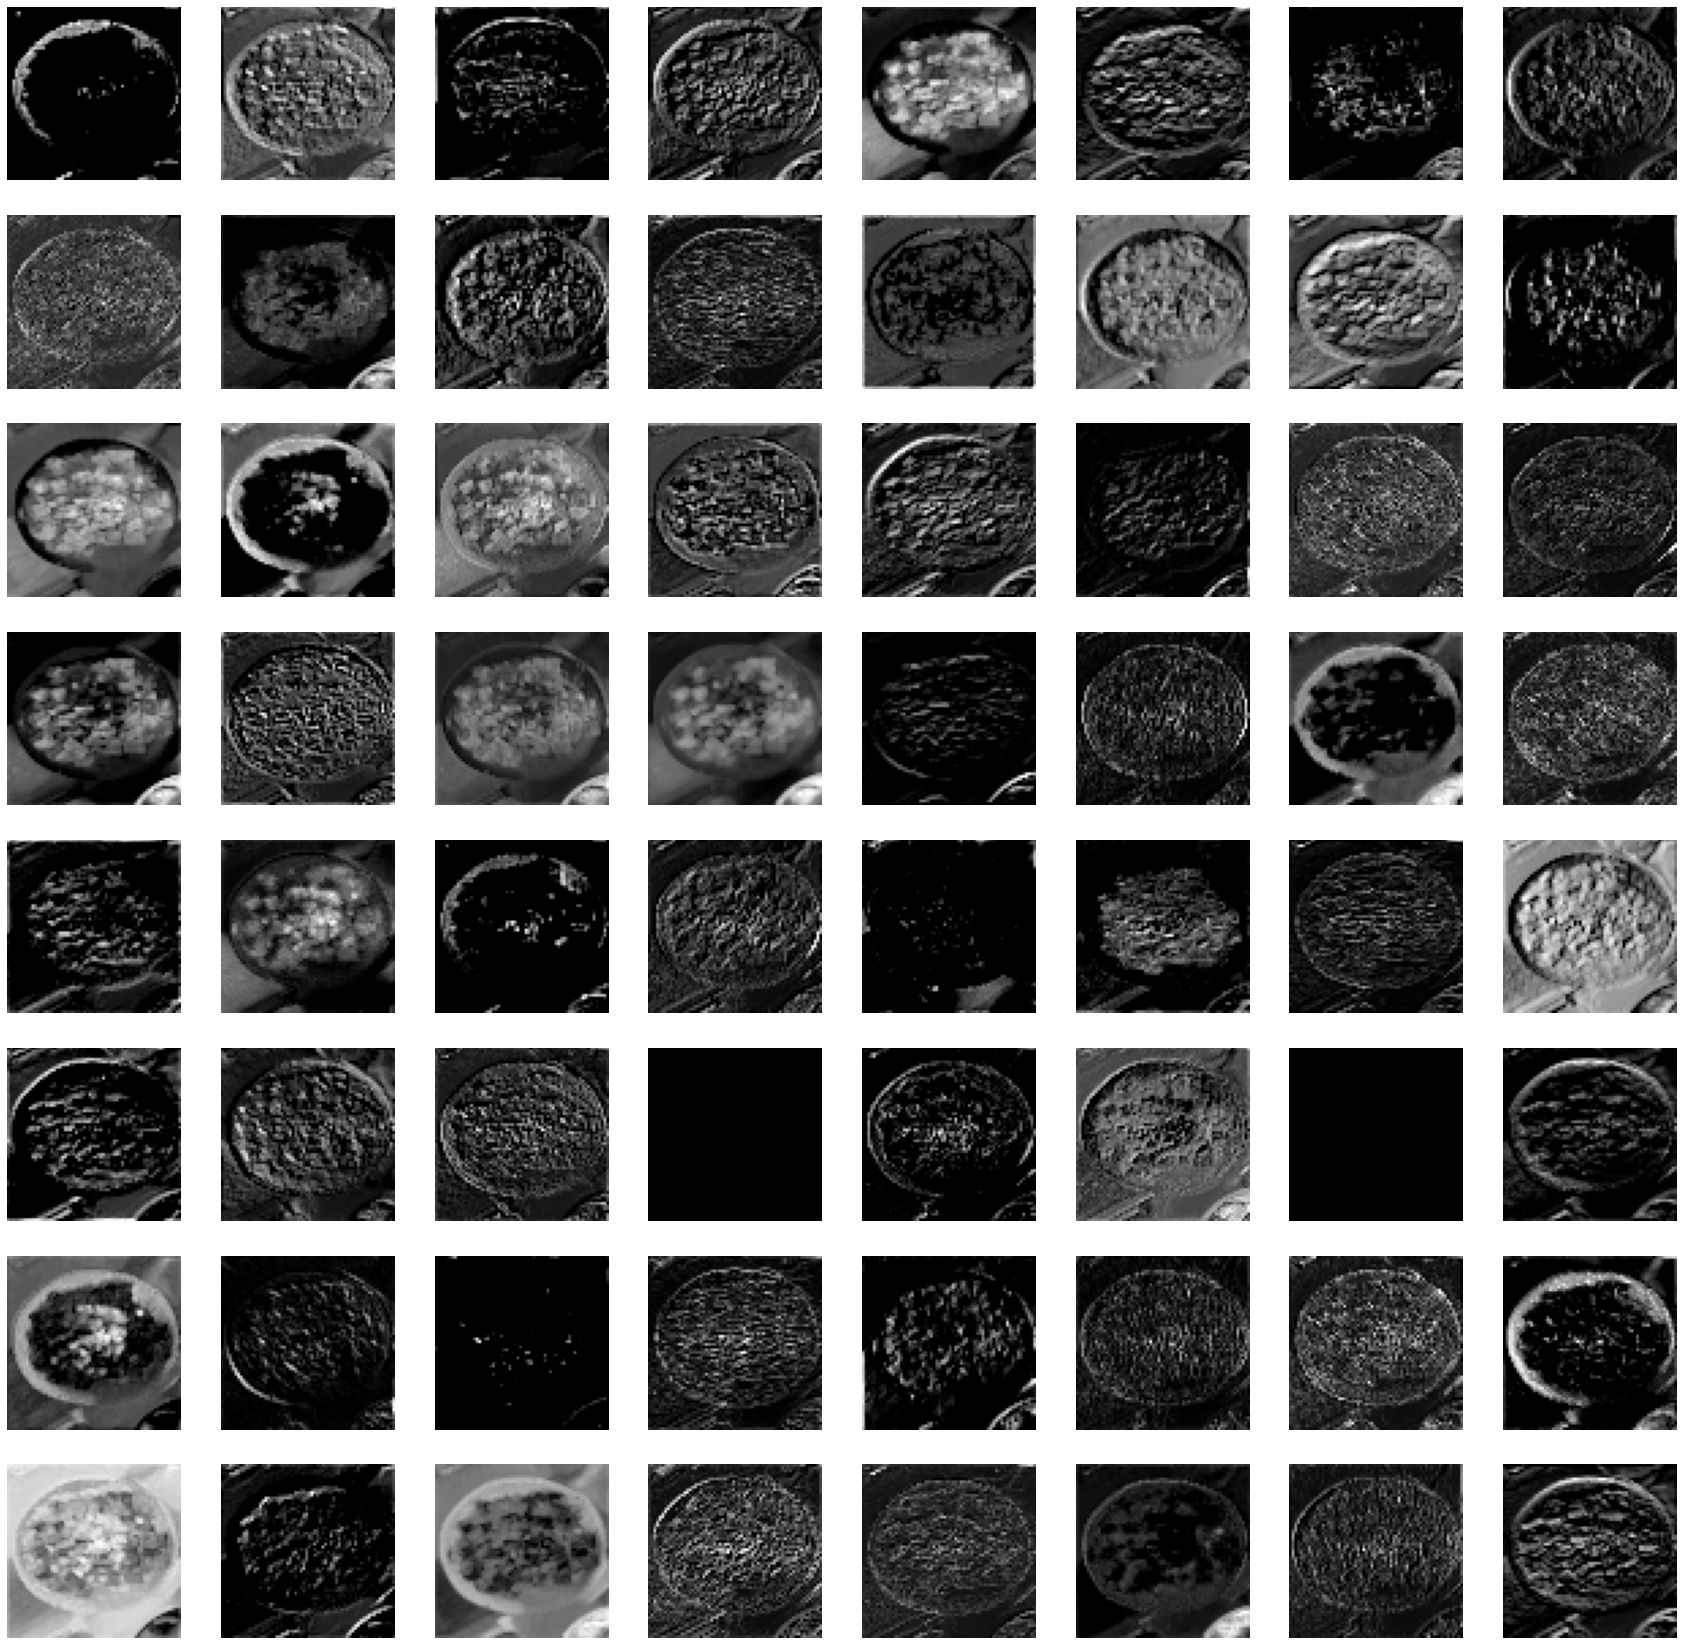

In [16]:
model = VGG16Classifier_features(1)
#print(train_dataset[2000][0].shape)
features = model(train_dataset[0][0].reshape((-1, 3, 128, 128)))
print(features.shape)
plt.figure(figsize=(30, 30))
plot_features(features, 8, 8)

torch.Size([1, 128, 32, 32])


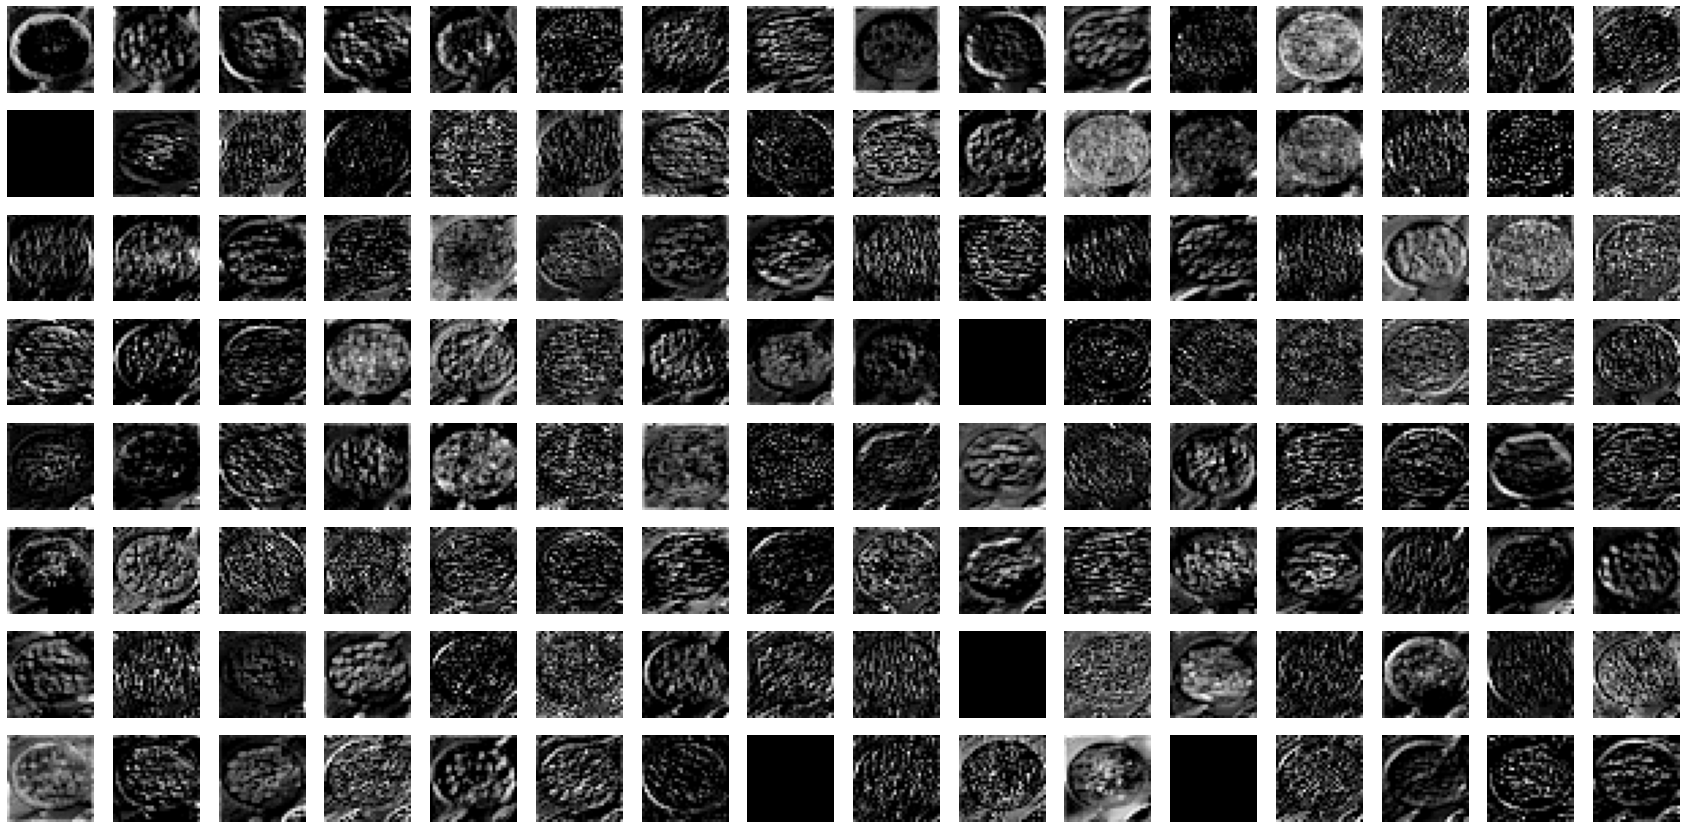

In [17]:
model = VGG16Classifier_features(2)
#print(train_dataset[2000][0].shape)
features = model(train_dataset[0][0].reshape((-1, 3, 128, 128)))
print(features.shape)
plt.figure(figsize=(30, 15))
plot_features(features, 8, 16)

torch.Size([1, 256, 16, 16])


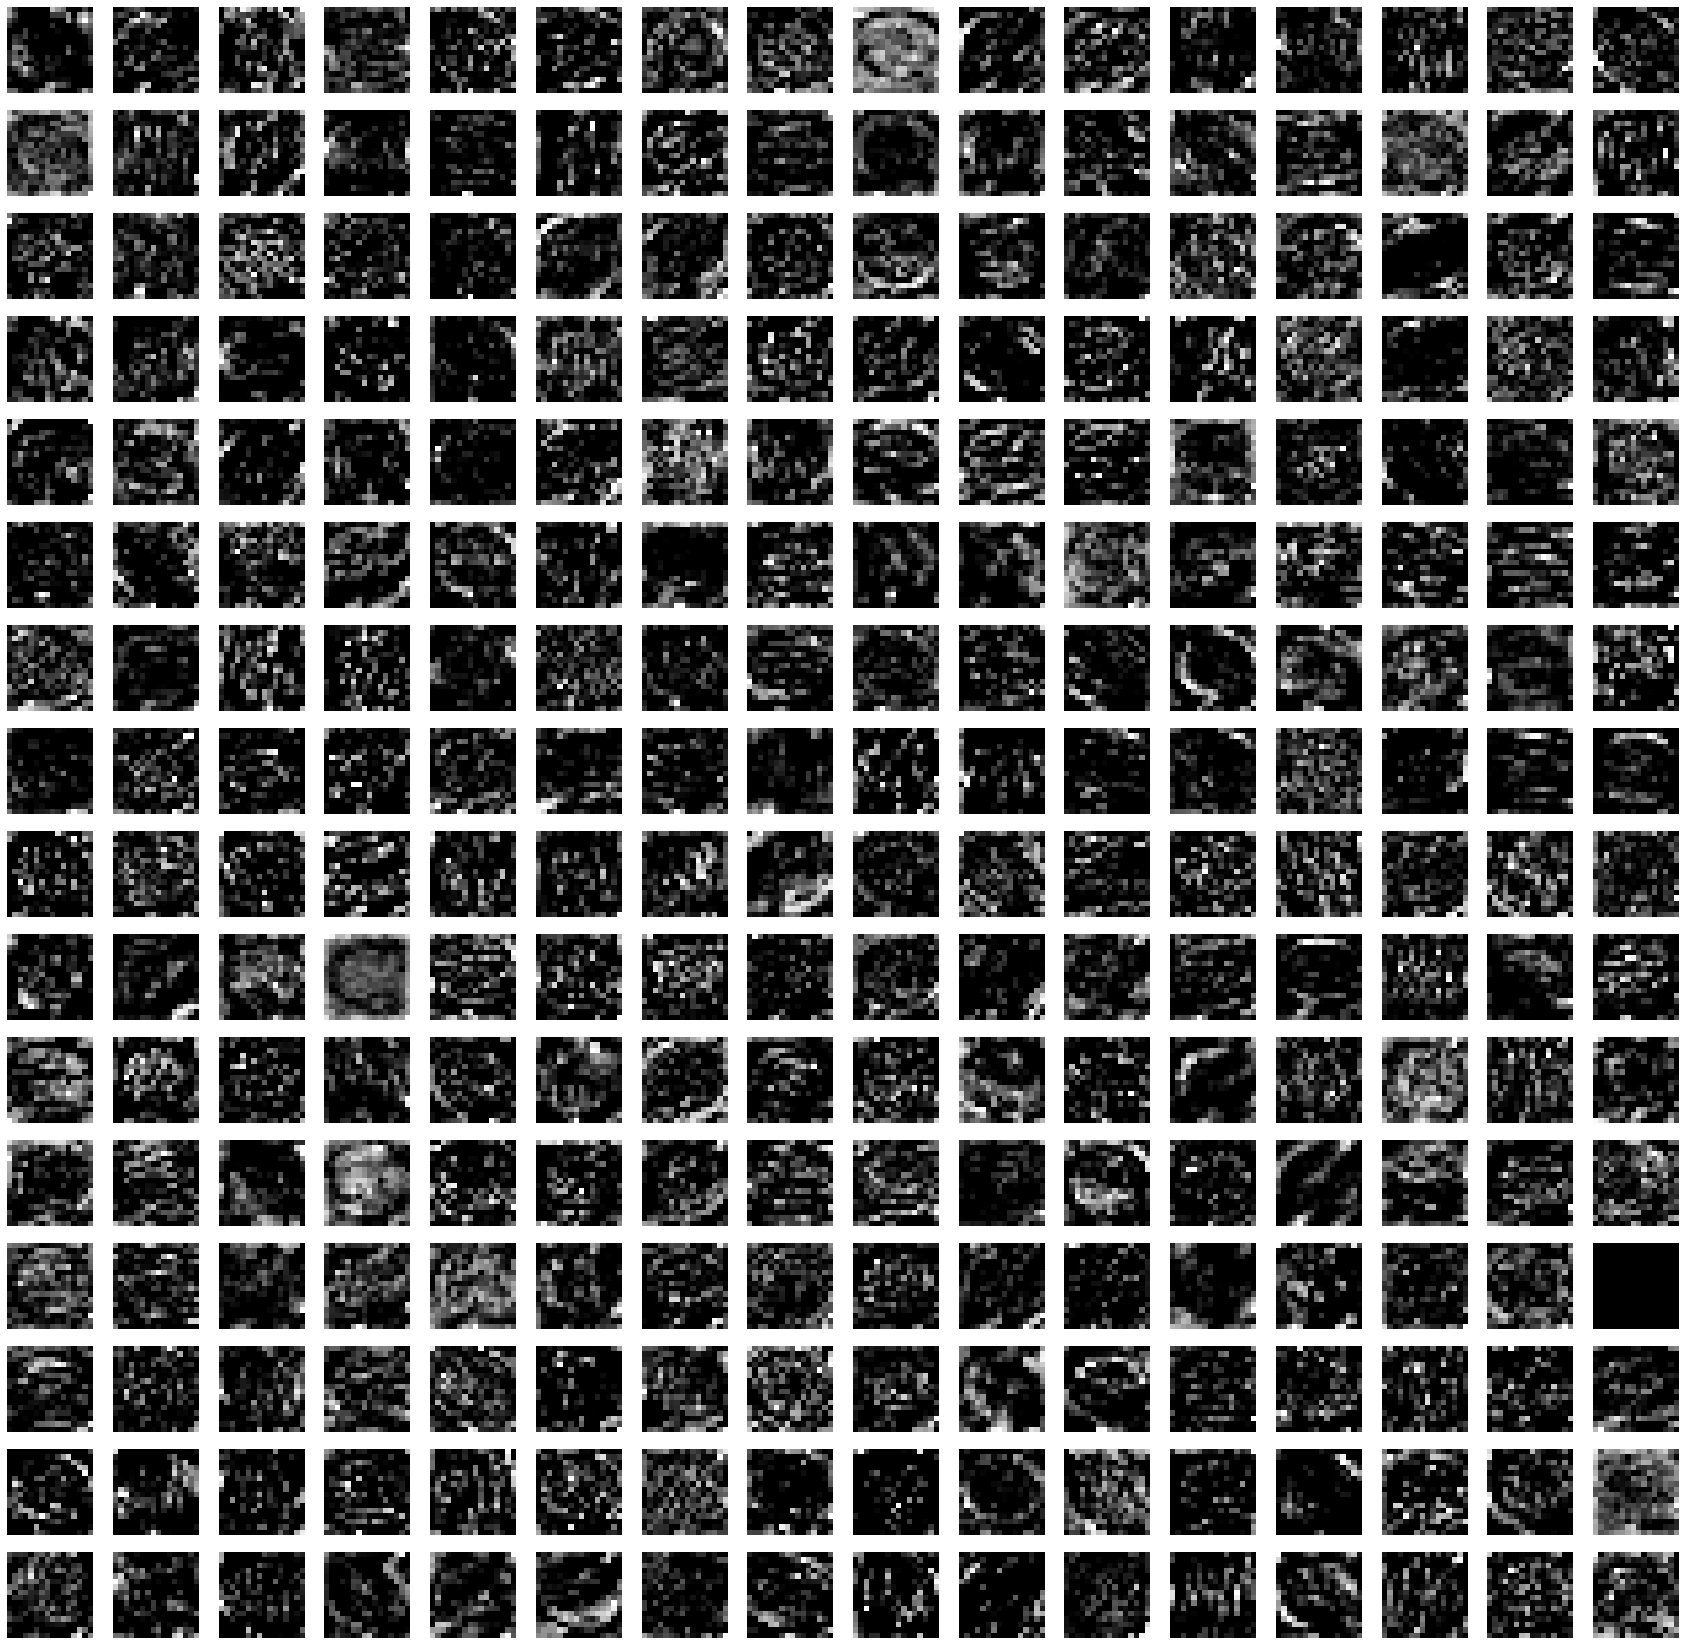

In [18]:
model = VGG16Classifier_features(3)
#print(train_dataset[2000][0].shape)
features = model(train_dataset[0][0].reshape((-1, 3, 128, 128)))
print(features.shape)
plt.figure(figsize=(30, 30))
plot_features(features, 16, 16)

torch.Size([1, 512, 8, 8])


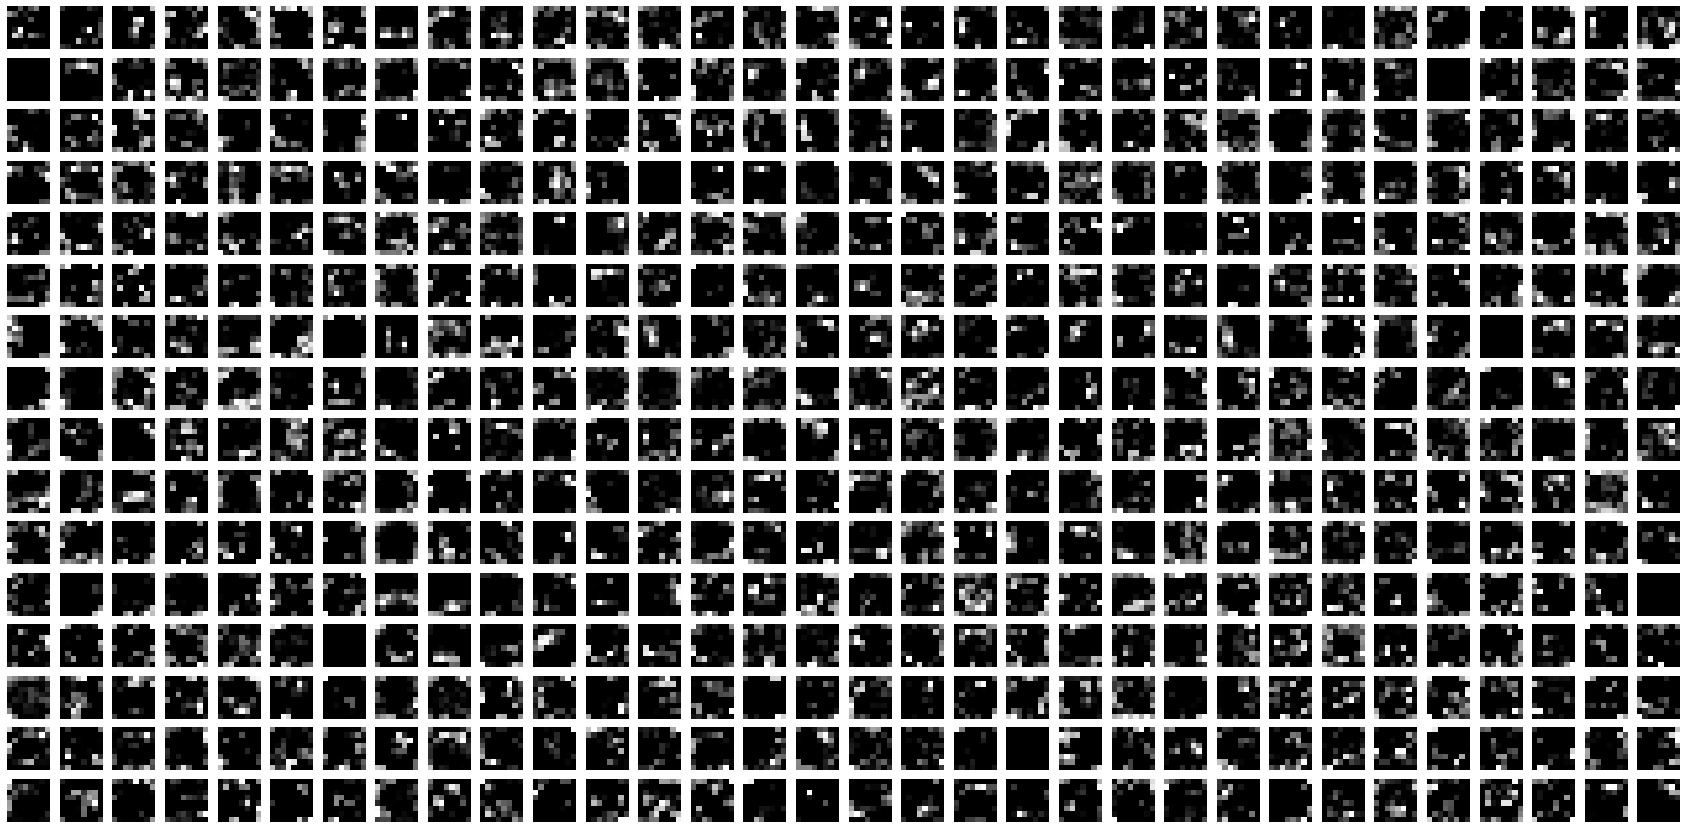

In [19]:
model = VGG16Classifier_features(4)
#print(train_dataset[2000][0].shape)
features = model(train_dataset[0][0].reshape((-1, 3, 128, 128)))
print(features.shape)
plt.figure(figsize=(30, 15))
plot_features(features, 16, 32)

In [ ]:
model = VGG16Classifier_features(5)
#print(train_dataset[2000][0].shape)
features = model(train_dataset[0][0].reshape((-1, 3, 128, 128)))
print(features.shape)
plt.figure(figsize=(30, 15))
plot_features(features, 16, 32)

## Features provided by pretrained alexnet

In [22]:
class AlexNetClassifier_features(nn.Module):
    def __init__(self, num_cnn):
        super().__init__()
        self.nn = alexnet(pretrained=True)
        #print(self.nn)
        conv_layer_num = [3, 6, -1]
        n_features = self.nn.features[-1]
        
        # do not allow backpropagation through
        # pre-trained model layers
        for param in self.nn.parameters():
            param.requires_grad = False
            
        
        self.nn = self.nn.features[:conv_layer_num[num_cnn - 1]]
    
    def forward(self, x):
        return self.nn(x)

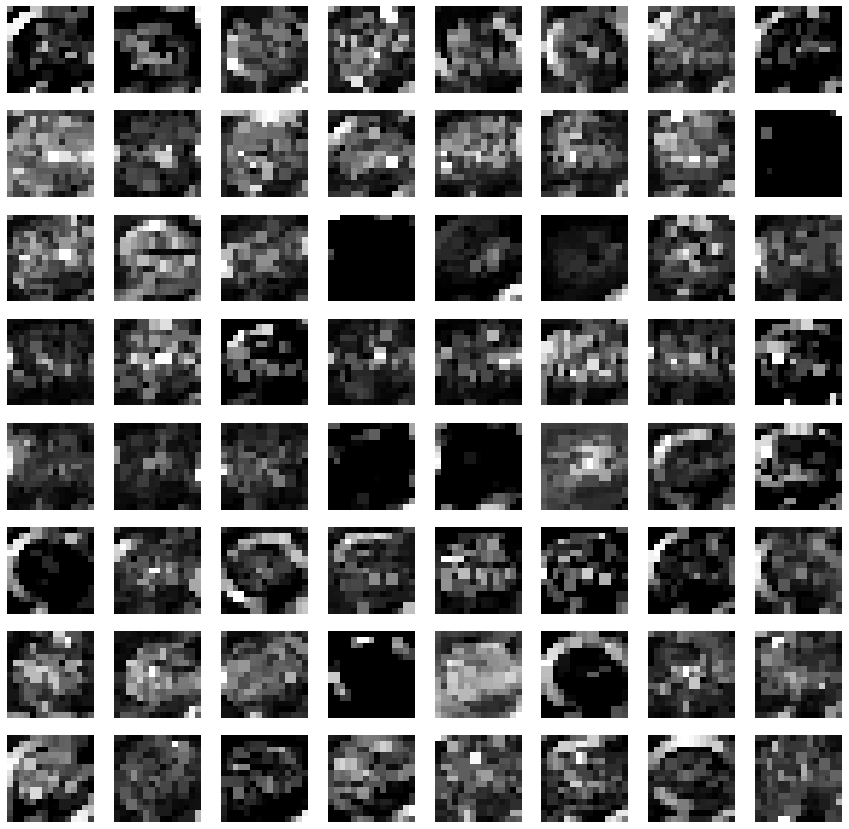

In [23]:
model = AlexNetClassifier_features(1)
features = model(train_dataset[0][0].reshape((-1, 3, 128, 128)))
#print(features.shape)
plt.figure(figsize=(15, 15))
plot_features(features, 8, 8)

torch.Size([1, 192, 7, 7])


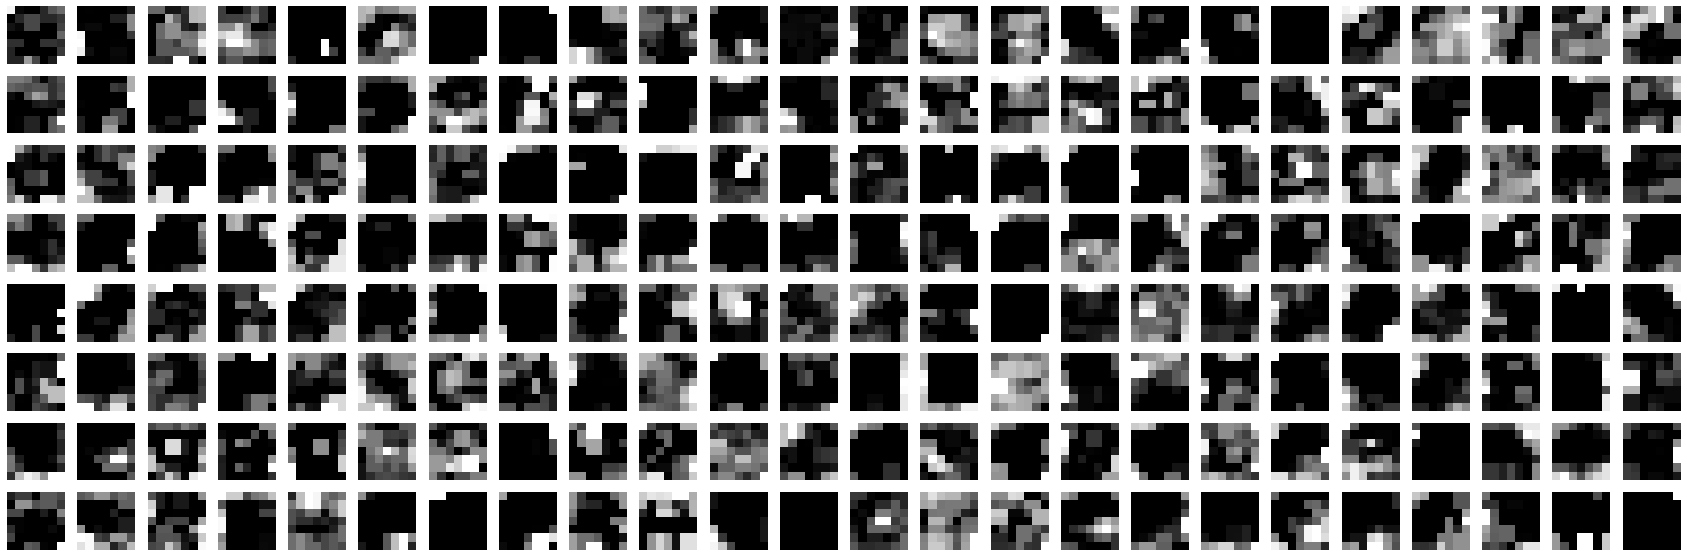

In [24]:
model = AlexNetClassifier_features(2)
features = model(train_dataset[0][0].reshape((-1, 3, 128, 128)))
print(features.shape)
plt.figure(figsize=(30, 10))
plot_features(features, 8, 24)

torch.Size([1, 256, 7, 7])


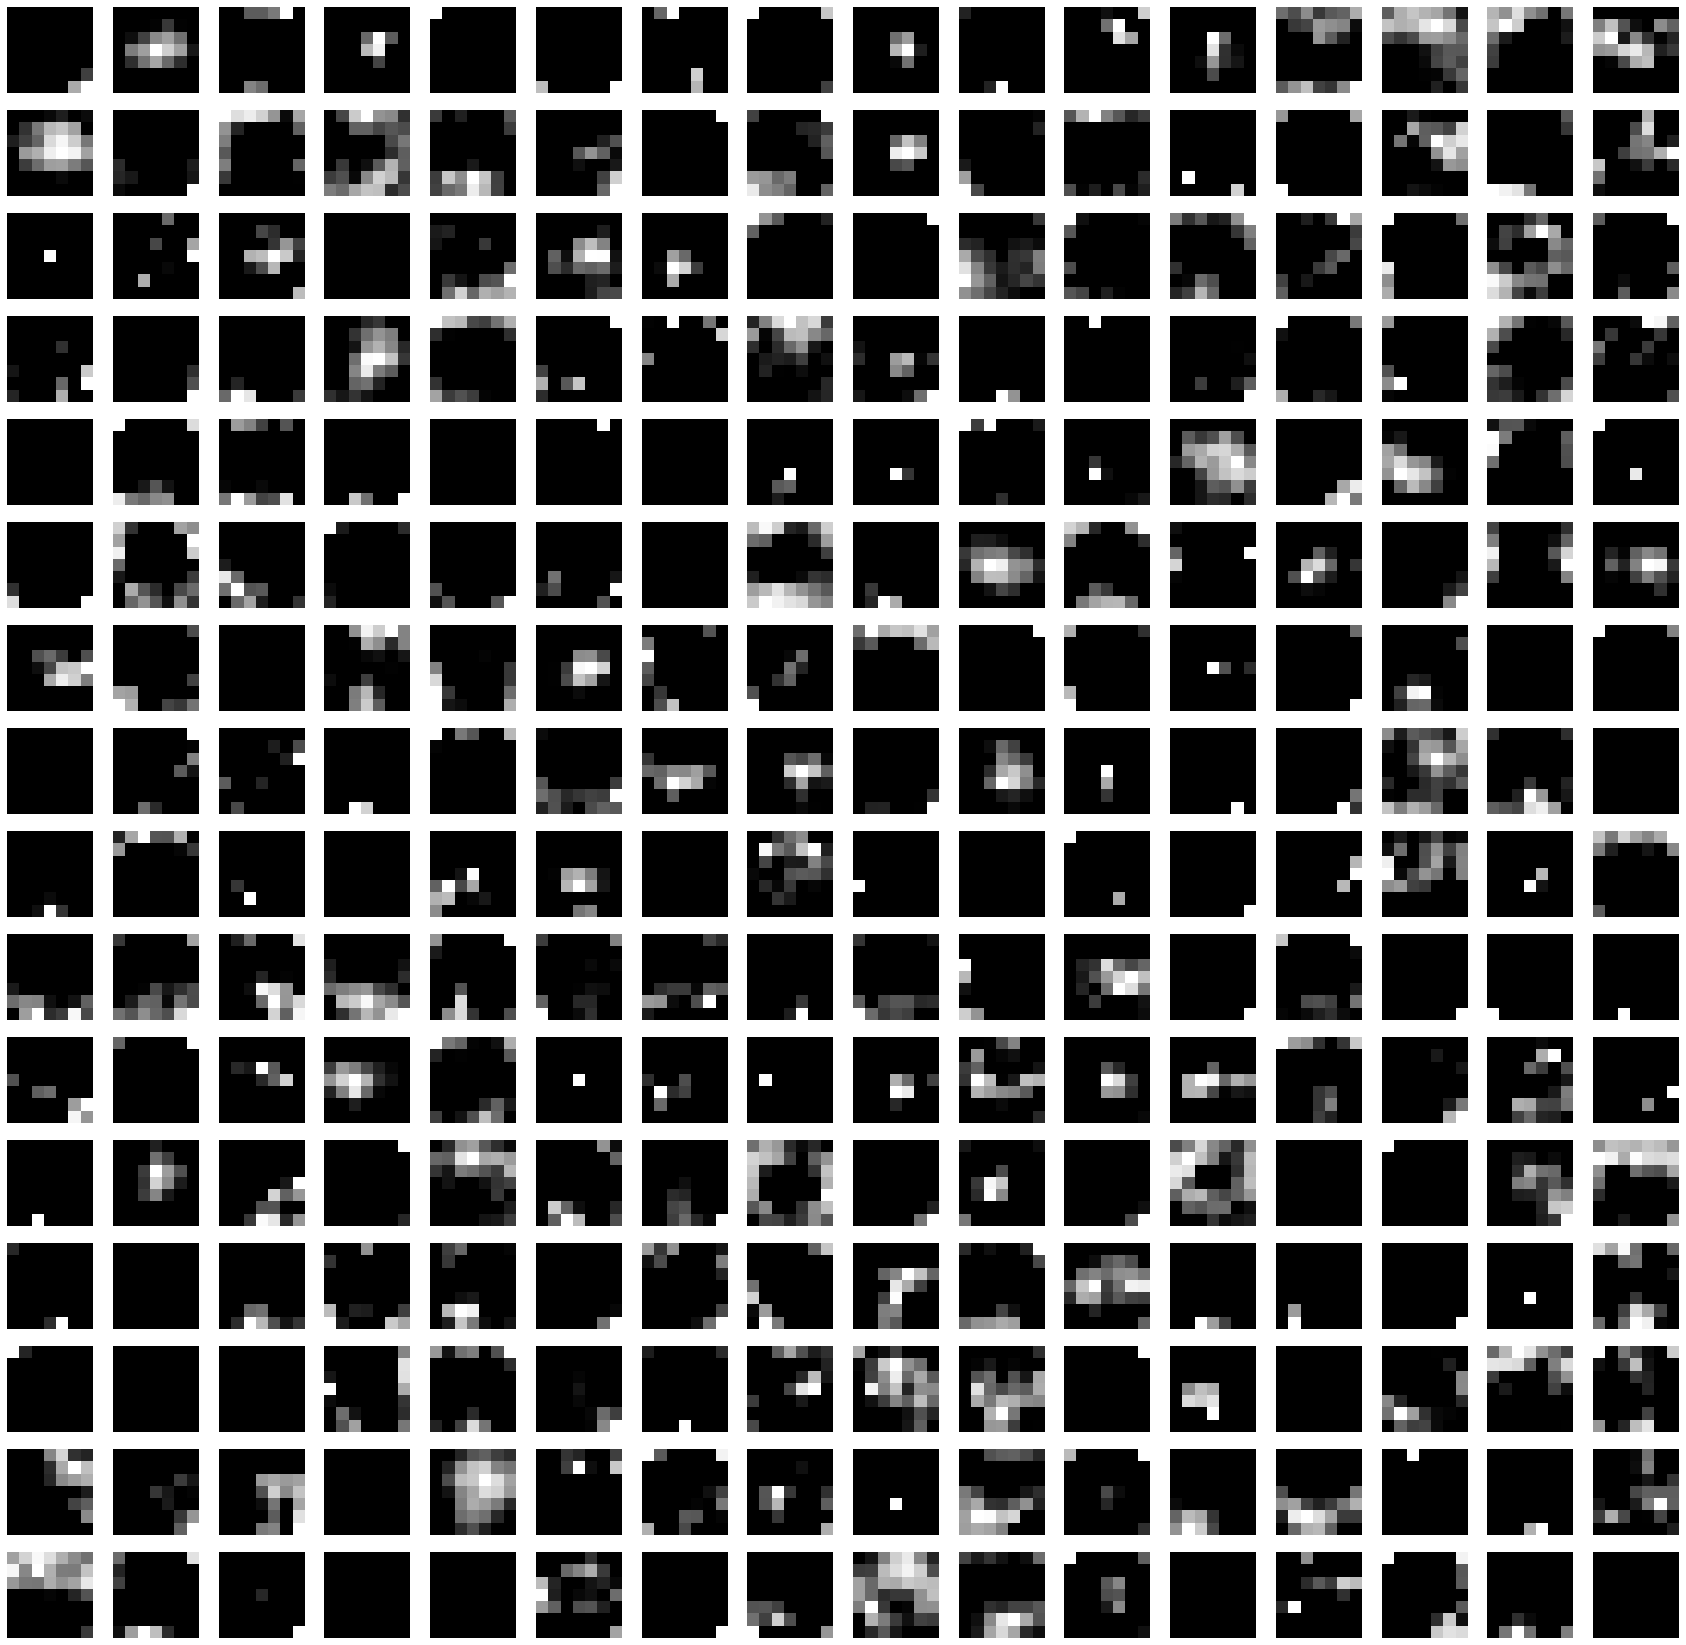

In [25]:
model = AlexNetClassifier_features(3)
features = model(train_dataset[0][0].reshape((-1, 3, 128, 128)))
print(features.shape)
plt.figure(figsize=(30, 30))
plot_features(features, 16, 16)

## Training

In [26]:
def evaluate_model(model,loader):
    model.to('cpu')
    # set model to evaluation mode before evaluation
    model.eval()
    predictions = torch.tensor([])
    targets = torch.tensor([])

    for _, (images, labels) in enumerate(tqdm(loader)):
        out = model(images)
        _, predicted = torch.max(out.data, 1)
        targets = torch.cat((targets, labels))
        predictions = torch.cat((predictions, predicted))

    accuracy = accuracy_score(targets, predictions) * 100
    f1 = f1_score(targets, predictions, average='macro')
    recall = recall_score(targets, predictions, average='macro')
    precision = precision_score(targets, predictions, average='macro')
    conf_matrix = confusion_matrix(targets, predictions)
    return conf_matrix,[accuracy, f1, recall, precision]

In [27]:
def training_loop(k_fold_num, model, train_loader, optimizer, loss, num_epoch, total_step):
    epoch_metrics = []

    model.to(device)
    for epoch in range(num_epoch):
        loss_val = 0.0
        acc_val = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            l = loss(outputs, labels)

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            
            loss_val = l.item()
            acc_val = (correct / total) * 100
            
            epoch_metrics.append({'fold':k_fold_num,'epoch':epoch + (i/total_step), 'loss':loss_val, 'accuracy':acc_val})
            
            print(f'Epoch [{epoch + 1}/{num_epoch}], Step [{i + 1}/{total_step}], Loss: {l.item():.4f}, Accuracy: {(correct / total) * 100:.2f}')

    torch.save(model.state_dict(), f'./{model.__class__.__name__}-model-fold'+ str(k_fold_num) +'.pt')
    return epoch_metrics

In [28]:
def run_kfold(model, train_dataset, num_folds, batch_size, num_epoch):
    total_scores = []
    num_classes = len(train_dataset.classes)
    total_confusion_matrix = np.zeros((num_classes,num_classes))
    
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True)
    
    epoch_metrics_df = pd.DataFrame(columns=['fold','epoch','loss','accuracy'])

    loss = nn.CrossEntropyLoss()
  

    # iterate over each fold
    for k_fold_num, (train_index, test_index) in enumerate(kf.split(train_idxs,train_labels)):
        model.to(device) # push training to either GPU/CPU
        
        print('Running K-Fold cross-validation on fold-', k_fold_num+1)
        
        train_fold = Subset(train_dataset, train_idxs[train_index])
        test_fold = Subset(train_dataset, train_idxs[test_index])

        train_loader = DataLoader(train_fold, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
        test_loader = DataLoader(test_fold, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)

        optimizer = Adam(model.parameters(), lr=0.001)
        total_step = len(train_loader)

        # run training
        epoch_metrics = training_loop(k_fold_num, model, train_loader, optimizer, loss, num_epoch, total_step)
        epoch_metrics_df = epoch_metrics_df.append(epoch_metrics, ignore_index=True)
        # run evaluation on validation fold 
        conf_matrix, scores = evaluate_model(model,test_loader)

        total_scores.append(scores)
        total_confusion_matrix = np.add(total_confusion_matrix,conf_matrix)
        
        # reset model parameters when going to the next fold
        if k_fold_num != num_folds - 1:
            model = model.__class__()
            
    scores_df = pd.DataFrame(total_scores,columns=['accuracy', 'f1', 'recall', 'precision'])

    return scores_df, epoch_metrics_df, total_confusion_matrix

In [29]:
def plot_training_metrics(training_metrics_df, num_folds):
    fig, ax = plt.subplots(2, figsize=(20,10))

    ax[0].set_xlabel('Number of epochs')
    ax[1].set_xlabel('Number of epochs')
    ax[0].set_ylabel('Training accuracy %')
    ax[1].set_ylabel('Training loss')
    
    for _fold in range(0, num_folds):
        temp_df = training_metrics_df.query('fold == @_fold')
        if _fold == 0:
            ax[0].set_title('Training Accuracy vs Number of Epochs')
            ax[1].set_title('Training Loss vs Number of Epochs')
        ax[0].plot(temp_df.epoch.values, temp_df.accuracy.values, label=f'fold-{_fold+1} accuracy')
        ax[1].plot(temp_df.epoch.values, temp_df.loss.values, label=f'fold-{_fold+1} loss')

    ax[0].legend()
    ax[1].legend()

## CNN training

In [ ]:
cnn = FoodCNN()
cnn_scores_df, cnn_epoch_metrics_df, cnn_total_confusion_matrix = run_kfold(cnn, train_dataset, 4, 400, 10)

### CNN confusion matrix

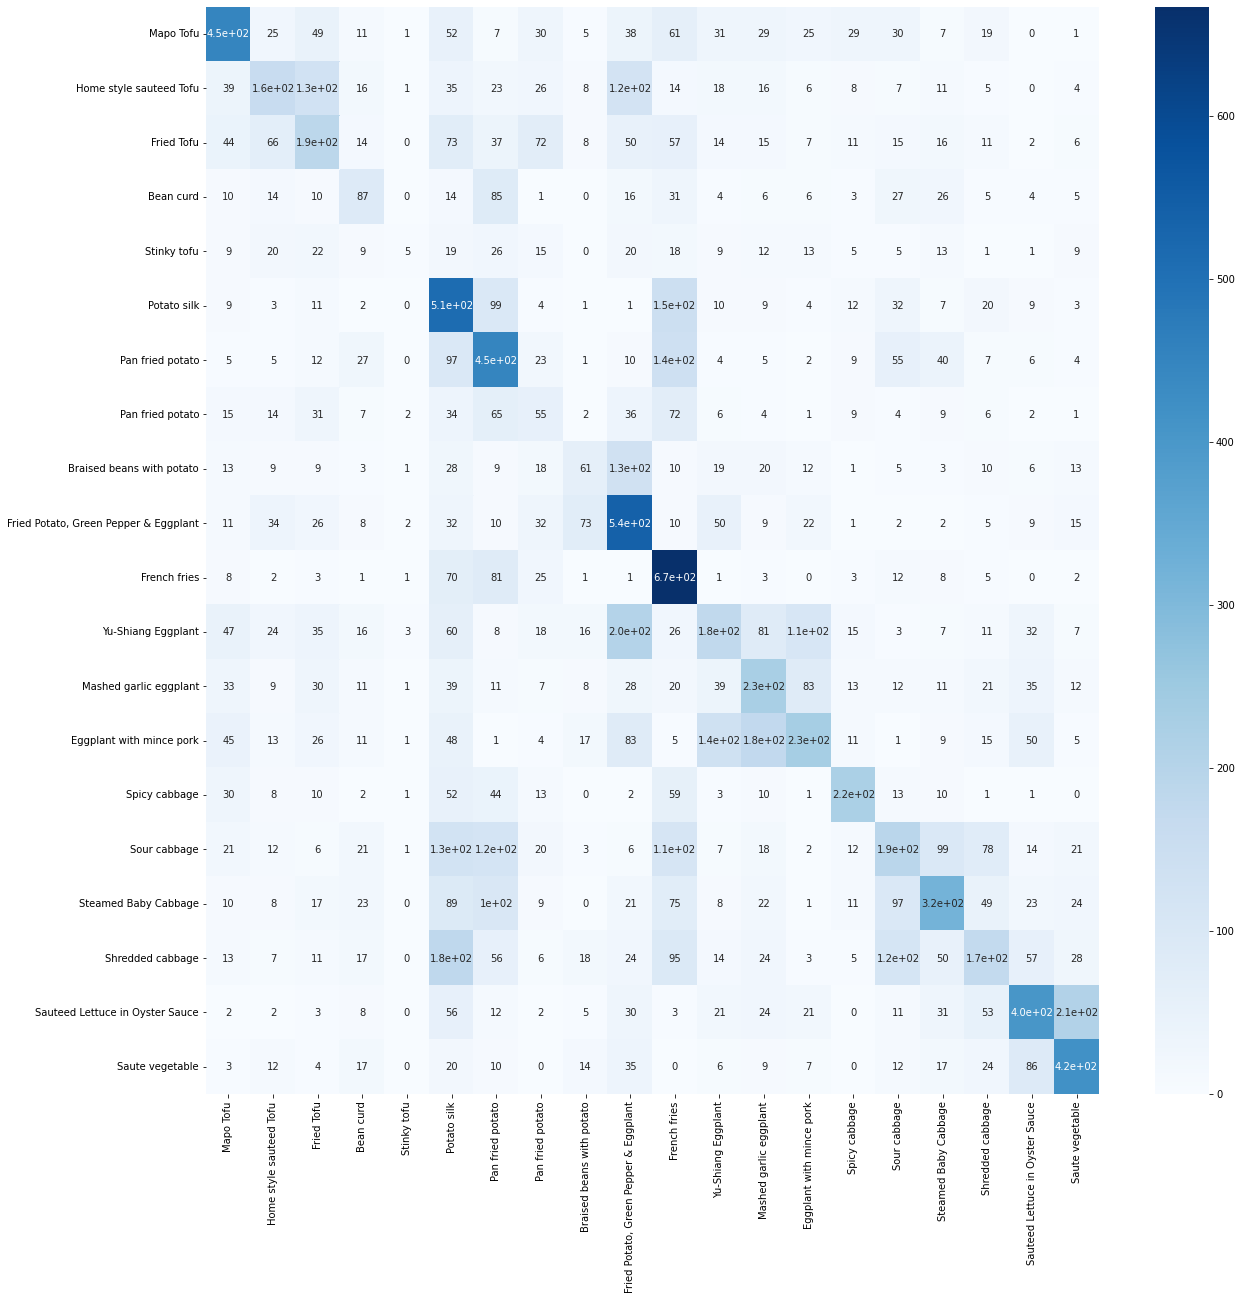

In [31]:
plt.figure(figsize=(20, 20))
food_list = classes['English Name']
sns.heatmap(cnn_total_confusion_matrix, xticklabels=food_list, yticklabels=food_list, annot=True, cmap='Blues')


### CNN training plotting

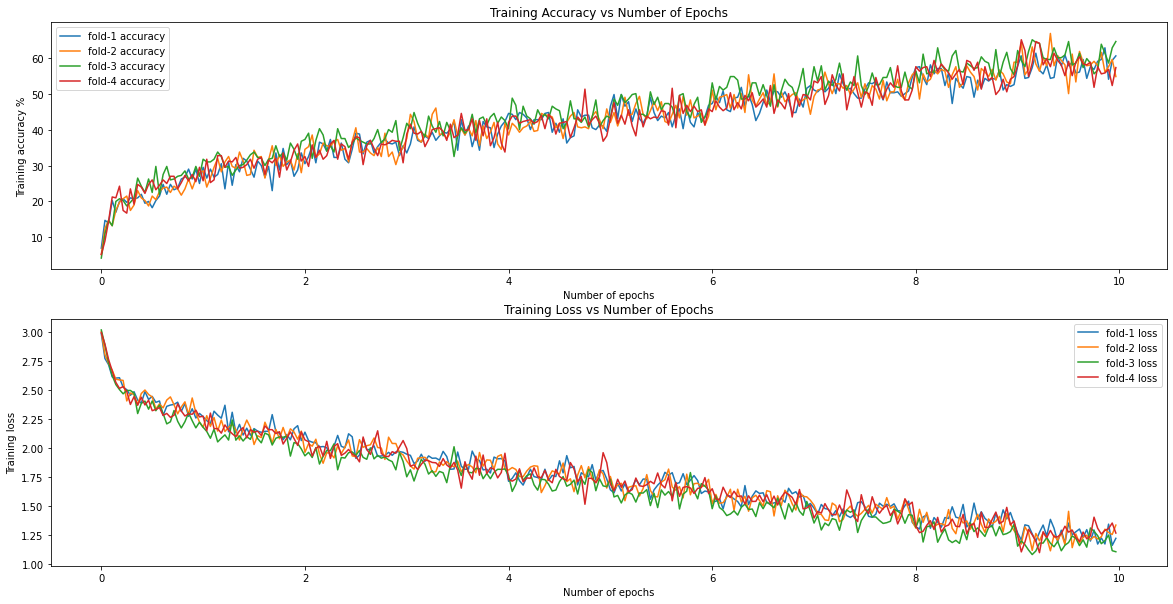

In [32]:
plot_training_metrics(cnn_epoch_metrics_df, 4)

## ResNet pretrained training

In [ ]:
resnet = ResNetClassifier()
res_scores_df, res_epoch_metrics_df, res_total_confusion_matrix = run_kfold(resnet, train_dataset, 4, 400, 10)

 ### ResNet confusion matrix

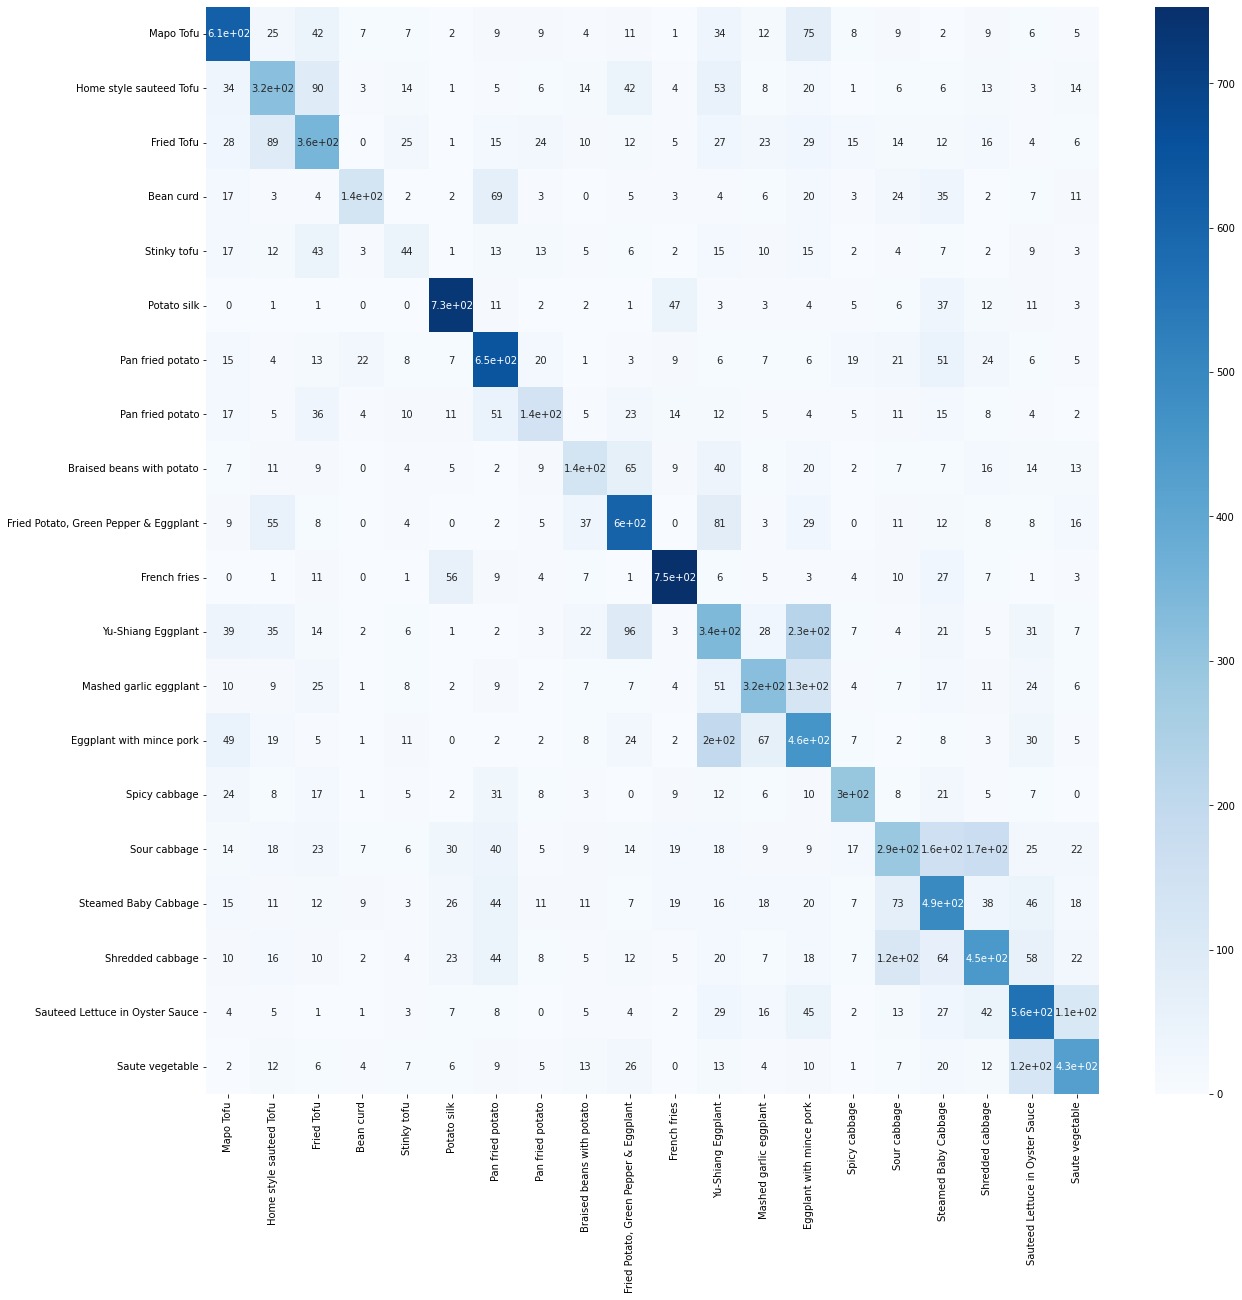

In [34]:
plt.figure(figsize=(20, 20))
food_list = classes['English Name']
sns.heatmap(res_total_confusion_matrix, xticklabels=food_list, yticklabels=food_list, annot=True, cmap='Blues')

### ResNet training plotting

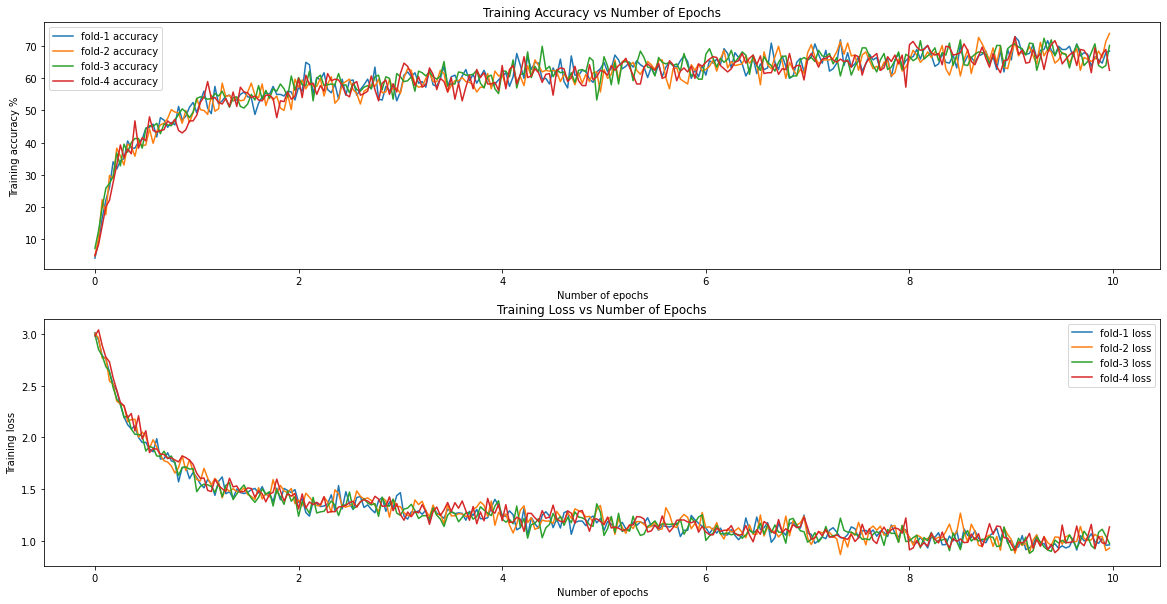

In [35]:
plot_training_metrics(res_epoch_metrics_df, 4)

## VGG pretrained training

In [ ]:
food_vgg = VGG16Classifier()
vgg_scores_df, vgg_epoch_metrics_df, vgg_total_confusion_matrix = run_kfold(food_vgg, train_dataset, 4, 1, 10)

 ### VGG confusion matrix

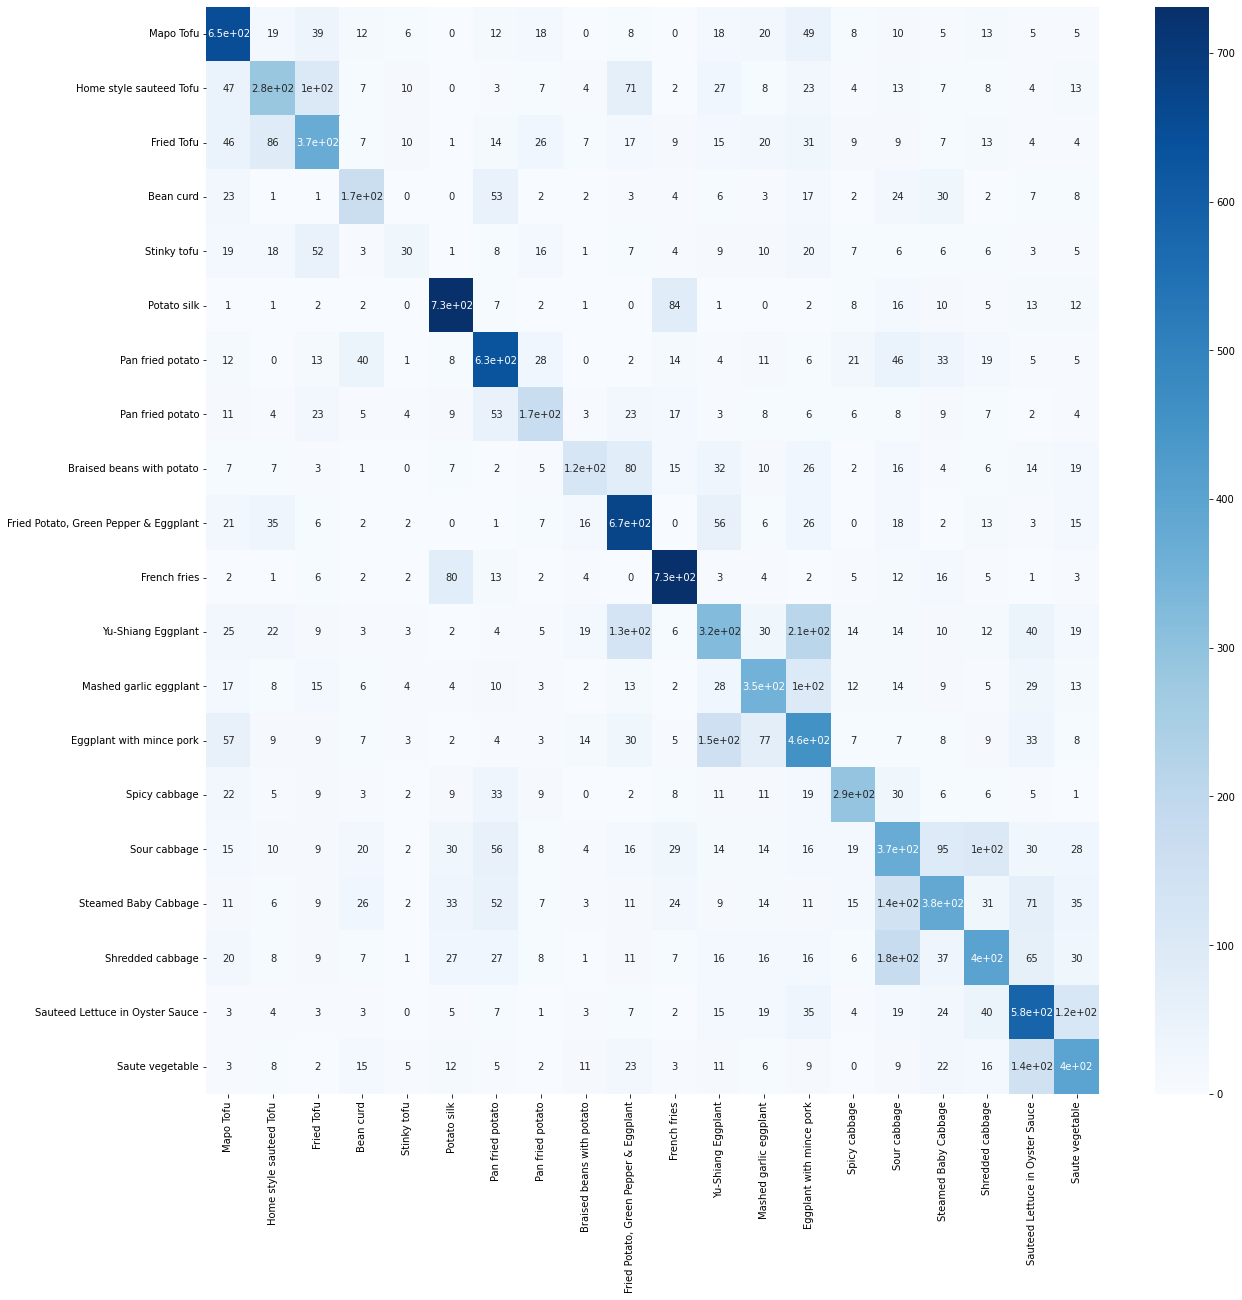

In [37]:
plt.figure(figsize=(20, 20))
food_list = classes['English Name']
sns.heatmap(vgg_total_confusion_matrix, xticklabels=food_list, yticklabels=food_list, annot=True, cmap='Blues')

### VGG training plotting

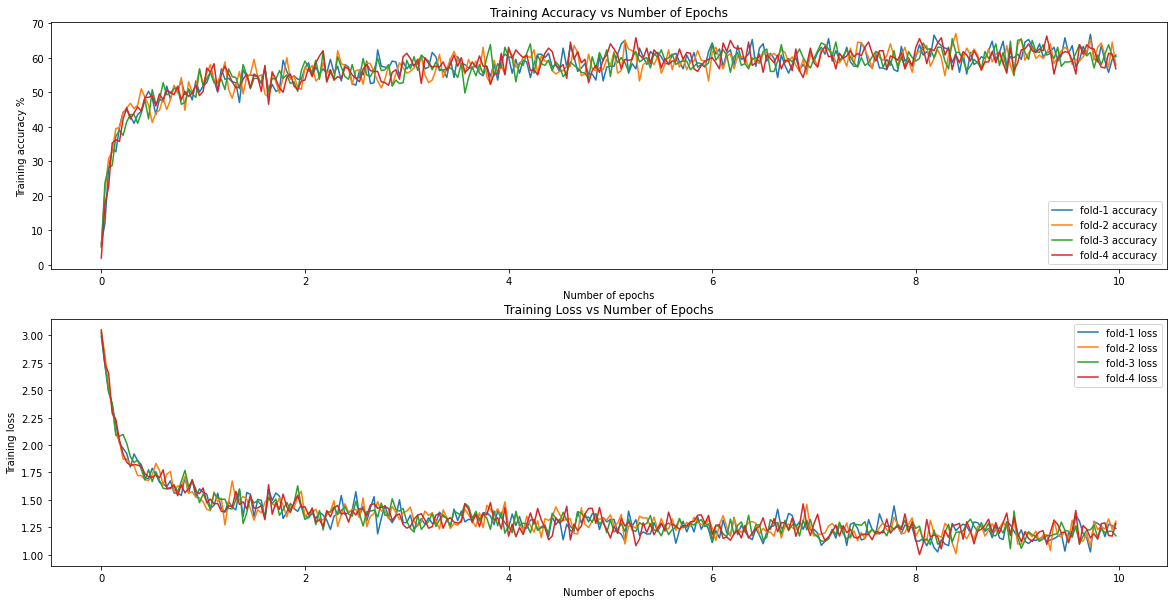

In [38]:
plot_training_metrics(vgg_epoch_metrics_df, 4)

## AlexNet pretrained training

In [39]:
food_alexnet = AlexNetClassifier()
alex_scores_df, alex_epoch_metrics_df, alex_total_confusion_matrix = run_kfold(food_alexnet, train_dataset, 4, 1, 10)

 ## AlexNet confusion matrix

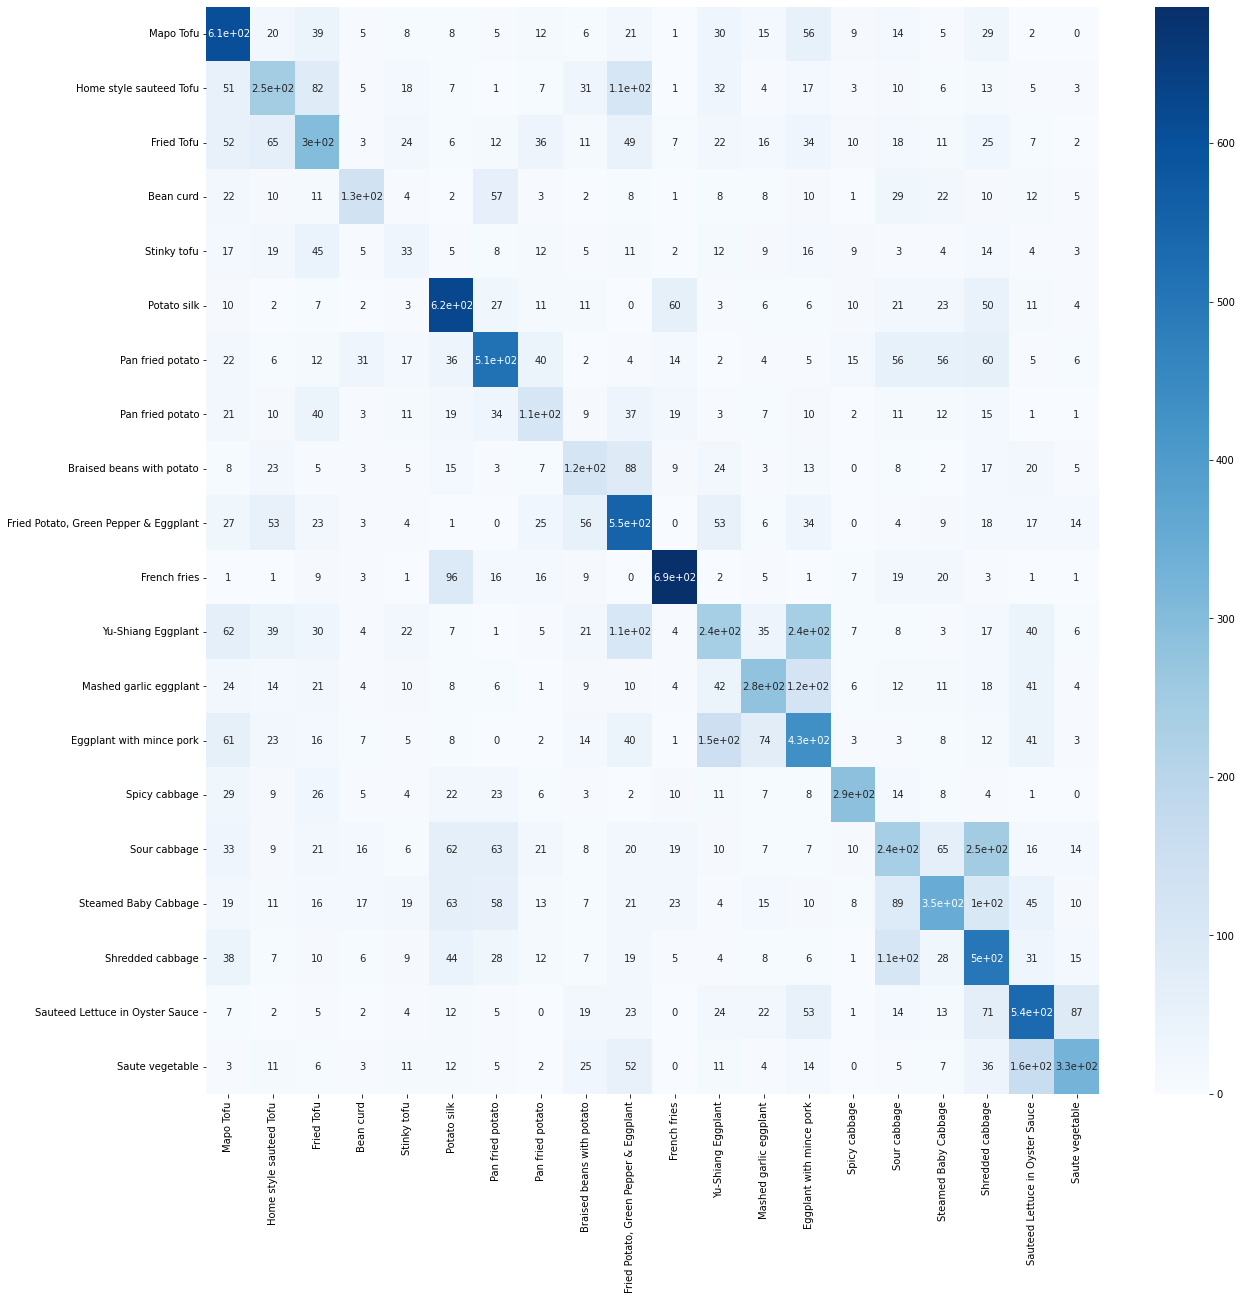

In [40]:
plt.figure(figsize=(20, 20))
food_list = classes['English Name']
sns.heatmap(alex_total_confusion_matrix, xticklabels=food_list, yticklabels=food_list, annot=True, cmap='Blues')

 AlexNet training plotting

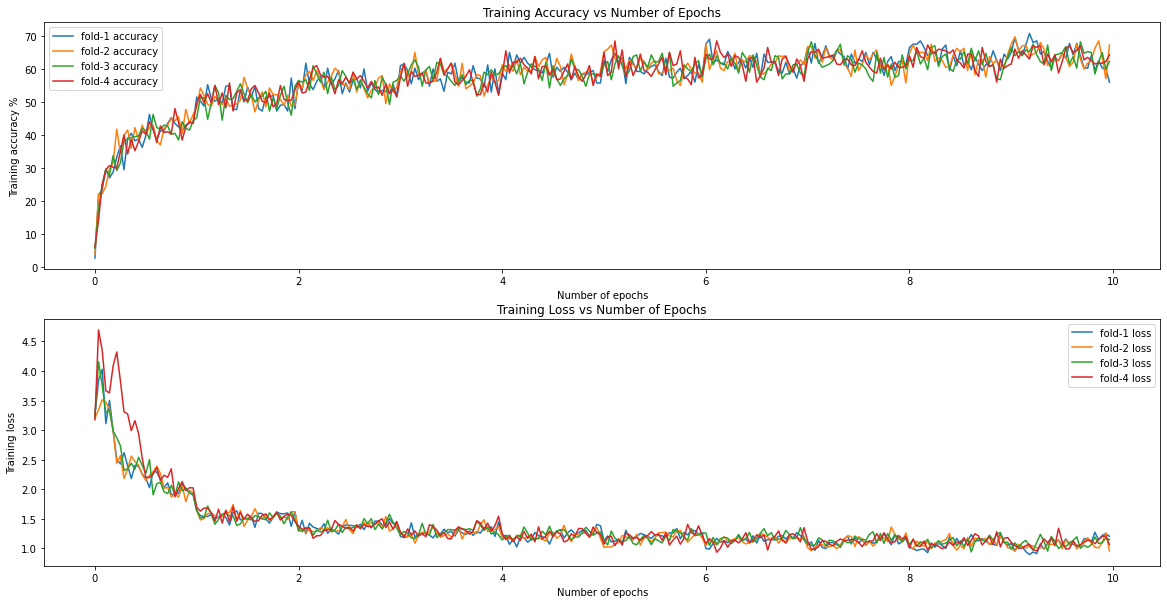

In [41]:
plot_training_metrics(alex_epoch_metrics_df, 4)

## GoogleNet training

In [ ]:
food_googlenet = GoogleNetClassifier()
google_scores_df, google_epoch_metrics_df, google_total_confusion_matrix = run_kfold(food_googlenet, train_dataset, 4, 400, 10)

### GoogleNet confusion matrix

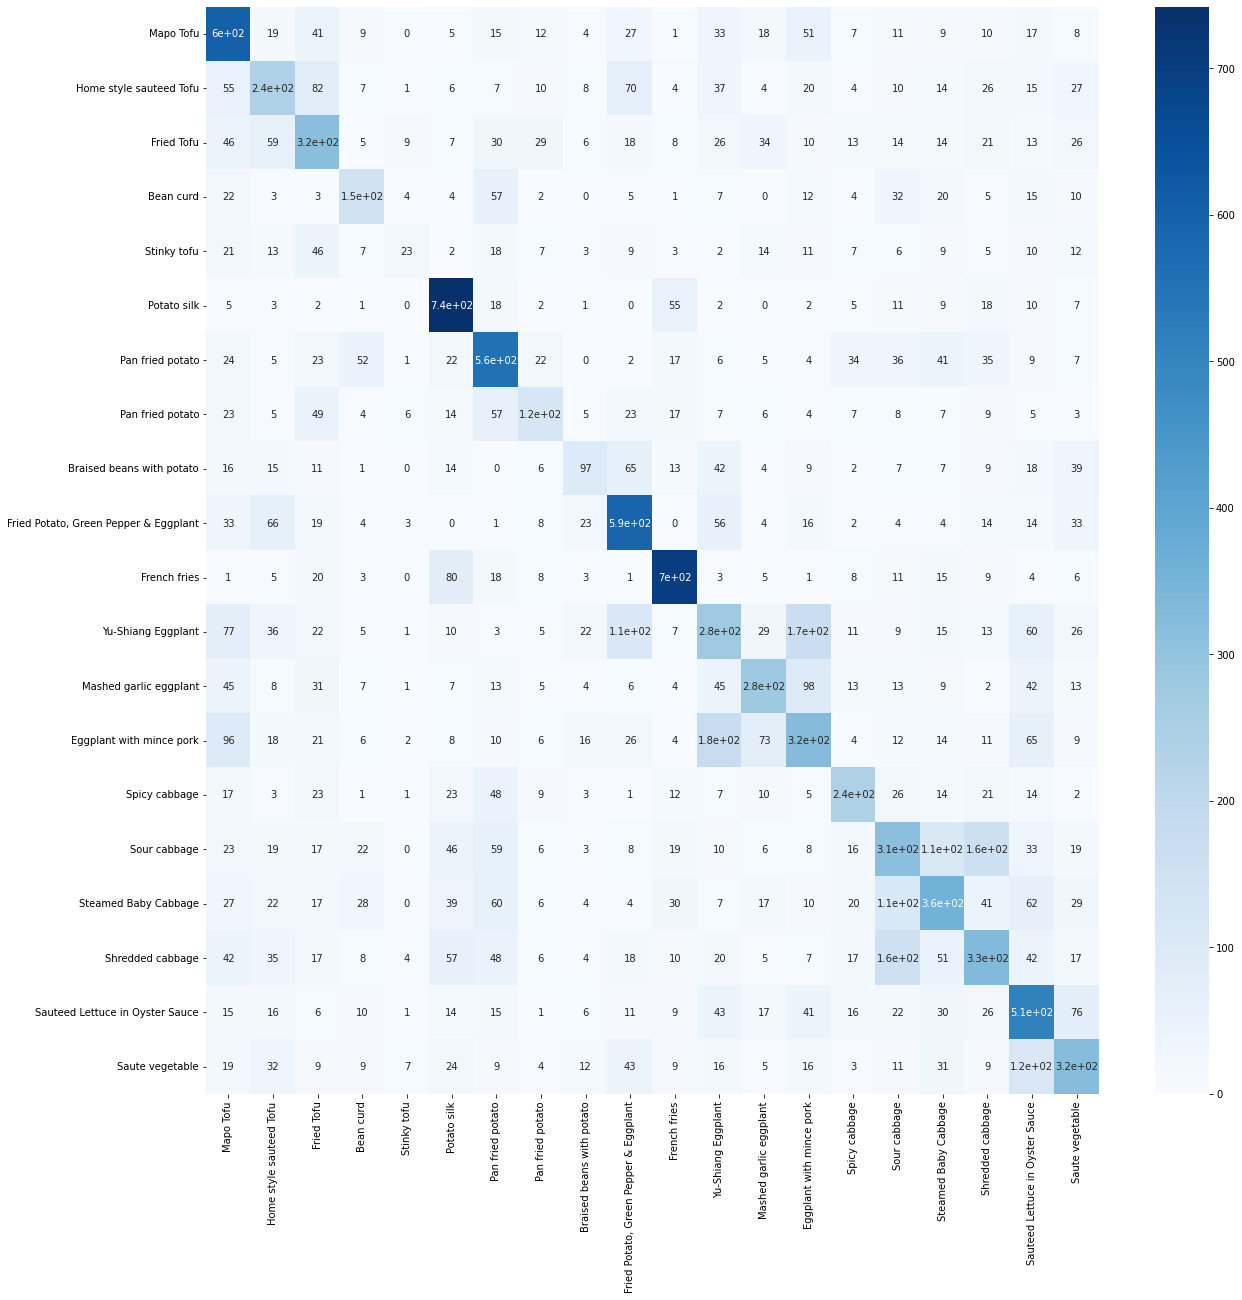

In [43]:
plt.figure(figsize=(20, 20))
food_list = classes['English Name']
sns.heatmap(google_total_confusion_matrix, xticklabels=food_list, yticklabels=food_list, annot=True, cmap='Blues')

### GoogleNet training plotting

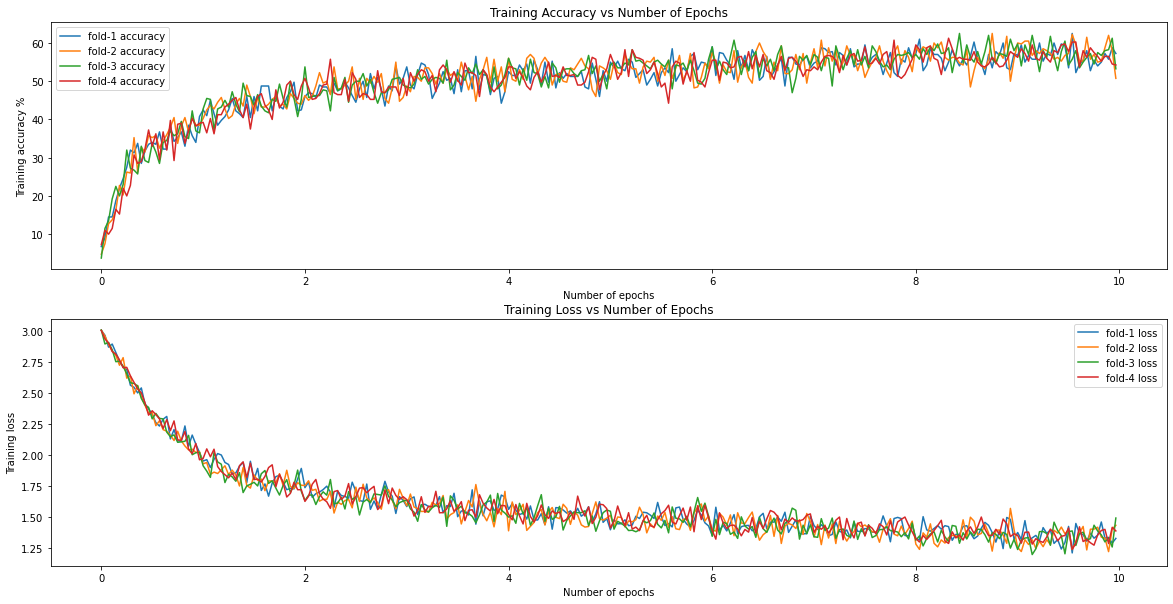

In [44]:
plot_training_metrics(google_epoch_metrics_df, 4)

# Predict on unseen images

In [58]:
def show_random_test():
  test_num = len(test_dataset)
  # print(test_num)
  img = test_dataset[random.randint(0, test_num)][0]
  img = img / 2 + 0.5
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.axis('off');
  pred = res(img.reshape(-1, 3, 128, 128))
  #print(pred.shape)
  values, indices = torch.topk(nn.functional.softmax(pred, dim=1), 5);
  values = values.reshape((-1,)).detach().numpy()
  indices = indices.reshape((-1,)).detach().numpy()
  #print(values*100)
  # print(indices)
  #print(classes)
  # print(classes[classes['List No.'].isin(indices)])
  predicted_possibilities = values * 100
  predicted_classes = classes['English Name'].values.tolist();
  # print(predicted_classes)
  for i in range(5):
    print("%s: %.3f%%" % (predicted_classes[indices[i]], predicted_possibilities[i]))

Steamed Baby Cabbage: 14.146%
Shredded cabbage: 14.083%
Sour cabbage: 11.809%
Yu-Shiang Eggplant: 11.211%
Eggplant with mince pork: 10.771%


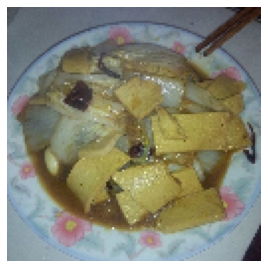

In [59]:
show_random_test()

Eggplant with mince pork: 14.059%
Sour cabbage: 12.349%
Yu-Shiang Eggplant: 11.211%
Steamed Baby Cabbage: 10.889%
Shredded cabbage: 10.525%


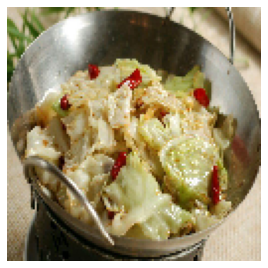

In [60]:
show_random_test()

Yu-Shiang Eggplant: 13.338%
Shredded cabbage: 13.182%
Sour cabbage: 11.289%
Eggplant with mince pork: 10.258%
Steamed Baby Cabbage: 8.683%


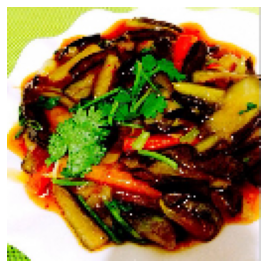

In [61]:
show_random_test()

Eggplant with mince pork: 16.373%
Yu-Shiang Eggplant: 14.414%
Sour cabbage: 7.414%
Stinky tofu: 7.168%
Home style sauteed Tofu: 7.071%


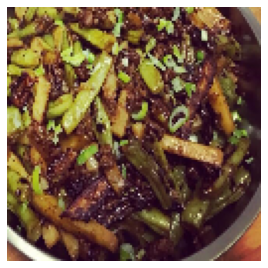

In [62]:
show_random_test()

Yu-Shiang Eggplant: 17.719%
Steamed Baby Cabbage: 10.875%
Eggplant with mince pork: 9.954%
Sour cabbage: 9.093%
Shredded cabbage: 9.068%


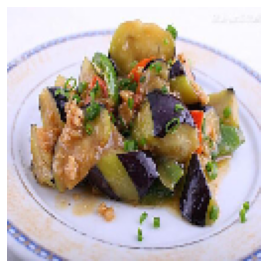

In [66]:
show_random_test()